# Getting Started With Cell Embeddings from scATAC-seq data
## Overview
A *cell embedding* is a low-dimensional representation of single-cell in an scATAC-seq workflow. Think of it as a single vector of dimensionality ~100 that summarizes the epigenetic state of a cell. Cell embeddings are useful for a variety of tasks, including visualization, clustering, and differential accessibility analysis. In this tutorial, we will learn how to use pretrained models from `scEmbed` to generate cell embeddings from scATAC-seq data. We will then use these embeddings to visualize the data and perform clustering.

Overwhlemingly, scATAC-seq datasets are represented and manipulated as *binary accessibilty matrices*. Breifly, these are matrices where each row represents a cell and each column represents a genomic region. The value of each entry is 1 if the region is accessible in the cell and 0 otherwise. For example, the following matrix represents a hypothetical dataset with 3 cells and 4 genomic regions:

| Cell | Region 1 | Region 2 | Region 3 | Region 4 |
|------|----------|----------|----------|----------|
| 1    | 1        | 0        | 1        | 0        |
| 2    | 0        | 1        | 1        | 0        |
| 3    | 1        | 1        | 0        | 1        |

These matrices are typically incredibly sparse, with most cells only having accessibilty at a small fraction of the genome. They are also extremely high-dimensional; matrices with > 1M features is common. This binary accessibility matrix is the input to `scEmbed`. We use [`scanpy`](https://github.com/scverse/scanpy) and their [`AnnData`](https://github.com/scverse/anndata) objects. These objects are a standard way of representing single-cell data in Python. We will use the `AnnData` object to represent our binary accessibility matrix.

## Installation
First, we need to install `scEmbed`. `scEmbed` is a part of the `gitk` package. We recommend using virtual environments for this:

In [ ]:
!pip install gitk
# or if using local version:
!pip install .

## Loading Data
For this tutorial we've curated a dataset already for you to use. It comes from [10X genomics](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard). 

*Note: when using a pre-trained model, `scEmbed` requires that your `AnnData` object have `chr`, `start`, and `end` values on the `.var` attribute of the object. This is because we use interval overlap analysis to find similar regions and recast the feature-space of the new data we are embedding*.

An example of how to do this is below:

```python
import scanpy as sc
import pandas as pd

adata = sc.read_h5ad("path/to/your/data.h5ad")

peaks = pd.read_csv("/path/to/your/peaks.bed", sep="\t", header=None)
peaks.columns = ["chr", "start", "end"]
adata.var = peaks
```

**The data we are using in this example already has this completed for you.**

### Retreive preprocessed data:

In [7]:
!mkdir -p pbmc
!wget "http://big.databio.org/scembed/data/pbmc_sampled.h5ad" -O "pbmc/pbmc.h5ad"

# or use the full dataset (careful, it's 12GB!):
# !wget "http://big.databio.org/scembed/data/pbmc.h5ad" -O "pbmc/pbmc.h5ad"

--2023-05-23 15:52:17--  http://big.databio.org/scembed/data/pbmc.h5ad
Resolving big.databio.org (big.databio.org)... 128.143.223.179
Connecting to big.databio.org (big.databio.org)|128.143.223.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13570752714 (13G) [application/octet-stream]
Saving to: ‘pbmc/pbmc.h5ad’

pbmc/pbmc.h5ad      100%[===================>]  12.64G  43.5MB/s    in 5m 17s  

2023-05-23 15:57:34 (40.8 MB/s) - ‘pbmc/pbmc.h5ad’ saved [13570752714/13570752714]



## Generating Embeddings
Now that we have the data, we can generate embeddings. This occurs in two steps:

1. Create a `Projector()`
2. Project some data

If this is your first time through the tutorial, the model will need time to download. This will take a few minutes. If you've already run this tutorial, the model will be cached and this step will be much faster.

In [1]:
# read in the data
import scanpy as sc

pbmc = sc.read_h5ad("pbmc/pbmc.h5ad")

In [2]:
# inspect 
pbmc

AnnData object with n_obs × n_vars = 10246 × 165434
    obs: 'barcode'
    var: 'chr', 'start', 'end'

In [3]:
# create projector
from gitk.scembed import Projector

model = Projector("databio/multiome")

/Users/nathanleroy/uva/lab/code/gitk/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/nathanleroy/uva/lab/code/gitk/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/nathanleroy/uva/lab/code/gitk/venv/lib/python3.10

In [5]:
len(model.model)

116490

In [6]:
# create embeddings (takes a few minutes)
# there will be three progress bars:
# 1. converting dataset to universe, 
# 2. creating documents, and 
# 3. projecting
pbmc = model.project(pbmc)

***** WARNING: File /Users/nathanleroy/.scembed/b.bed has inconsistent naming convention for record:
chr1	9776	10668

***** WARNING: File /Users/nathanleroy/.scembed/b.bed has inconsistent naming convention for record:
chr1	9776	10668

100%|██████████| 10246/10246 [01:28<00:00, 116.16it/s]


In [7]:
# insepct the results
pbmc.obsm['embedding'].shape

(10246, 100)

## Analyzing Embeddings
Pretty fast, huh? We can now analyze the embeddings. First, let's visualize them. We'll use `umap`. We'll also color the cells by their cluster assignment. We'll use `leiden` clustering for this. This occurs in three steps:

1. `scanpy.pp.neighbors()` to compute the nearest neighbors of each cell
2. `scanpy.tl.leiden()` to compute the UMAP embedding and associated cluster assignments
3. `umap.Umap()` to compute the UMAP embedding

We can then run visualizations with seaborn and matplotlib. We'll color the cells by their cluster assignment.

In [16]:
# run leiden clustering on embeddings
sc.pp.neighbors(pbmc, use_rep='embedding', n_neighbors=10)
sc.tl.leiden(pbmc, resolution=0.25)

In [17]:
import umap

reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(pbmc.obsm['embedding'])

# attach umaps back to pbmc object
pbmc.obsm['umap'] = umap_embedding
pbmc.obs['umap1'] = umap_embedding[:, 0]
pbmc.obs['umap2'] = umap_embedding[:, 1]

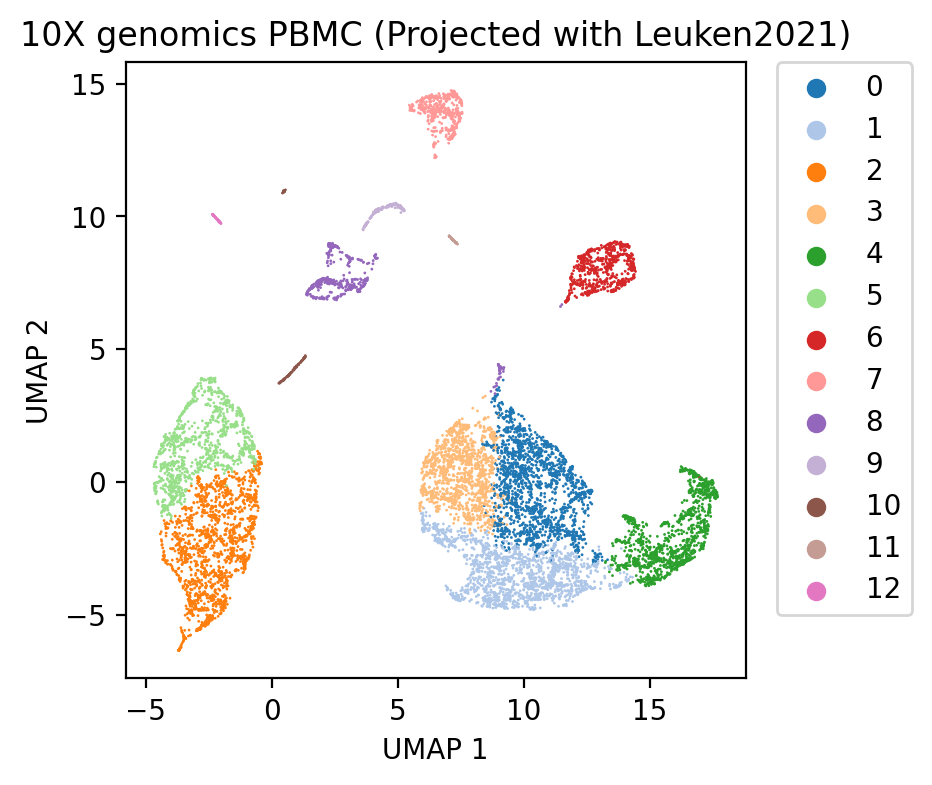

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    data=pbmc.obs,
    x='umap1',
    y='umap2',
    hue='leiden',
    palette='tab20',
    linewidth=0,
    s=1,
    ax=ax
)

# legend to upper right
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("10X genomics PBMC (Projected with Leuken2021)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

fig.savefig("pbmc/pbmc_leucken2021_proj_leiden.pdf", bbox_inches='tight')